# Is there study bias on proteins with pathogenic mutations?
We are going to explore the relationship between mutations and PTMs.  Specifially, we will test the hypothesis that pathogenic mutations are more likely to have PTMs nearby.  Before we begin, we must first explore what dataset of mutations and proteins we should consider. This code will explore whether there is study bias on proteins with pathogenic mutations, indicating we should control for study bias.

This code is specific for the **dbSNP** mutations dataset.

In [30]:
# Setup the workspace, 
from proteomeScoutAPI import ProteomeScoutAPI
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd 
import pickle

#set this to 0 if you would like to perform analysis on the entire set, 1 means we will remove extreme 
# outlier proteins in terms of lenght, GO annotations, mutations, or PTMS
FILTER = 1 

# load the ProteomeScout data (all data from the ProtomeScoutAPI)
%matplotlib inline
#proteomeScoutFile = '/Users/knaegle/HG/knaegle_repo/mutationsAnalysis/data/proteomescout_mammalia_20150201.tsv'
proteomeScoutFile = '/Users/alex/Dropbox/WASHU/naegle/mutants_paper/data/proteomescout_mammalia_20150726.tsv'

PTM_API = ProteomeScoutAPI(proteomeScoutFile)


In [32]:
# get all human protein IDs - uniKeys becomes a unique list of the IDs 
# associated with human protein
uniKeys = PTM_API.uniqueKeys
humanIds = []
for key in uniKeys:
    species = PTM_API.get_species(key)
    if species == 'homo sapiens':
        humanIds.append(key)


In [33]:
print "The number of proteins being examined is: %i" % (len(humanIds))

The number of proteins being examined is: 21968


In [35]:
# for every protein get the number of GO terms, PTMs and mutations. Collect a flag if at least one mutation is 
# known to be pathogenic so we can separate those later
protDict = {}
for ID in humanIds:
    tempProtDict = {}
    #handle an error 
    tempProtDict['sequence'] = PTM_API.get_sequence(ID)
    tempProtDict['GO_terms'] = PTM_API.get_GO(ID)
    tempProtDict['mutations'] = PTM_API.get_mutations(ID)
    tempProtDict['PTMs'] = PTM_API.get_PTMs(ID)
    
    # mutation will be set of 1 or 2 in case of an error, so this just
    # checks that and acts accordingly
    if not isinstance(tempProtDict['mutations'] , (int, long)):
        protDict[ID] = tempProtDict
    else:
        print "Error, not adding ID:%s to dictionary since there was a problem"%(ID)
    

Error: Not the same number of annotations (43) and mutations (27)

Error, not adding ID:49255 to dictionary since there was a problem
Error: Not the same number of annotations (7) and mutations (5)

Error, not adding ID:49574 to dictionary since there was a problem
Error: Not the same number of annotations (9) and mutations (7)

Error, not adding ID:53705 to dictionary since there was a problem
Error: Not the same number of annotations (13) and mutations (11)

Error, not adding ID:53797 to dictionary since there was a problem
Error: Not the same number of annotations (14) and mutations (12)

Error, not adding ID:53906 to dictionary since there was a problem
Error: Not the same number of annotations (10) and mutations (6)

Error, not adding ID:114257 to dictionary since there was a problem
Error: Not the same number of annotations (9) and mutations (7)

Error, not adding ID:114267 to dictionary since there was a problem
Error: Not the same number of annotations (11) and mutations (9)

E

In [36]:
print "After parsing for mutations and what not we are dealing with %i protein " % len(protDict)

After parsing for mutations and what not we are dealing with 21955 protein 


In [5]:
# create matched vectors of our items of interest
num_GO = []
num_muts = []
num_PTMs = []
seqLength = []
pathoStatus = []
protIds = []

# for each ID in the protein dictionary
for ID in protDict:
    val = 0
    
    # check if that mutation is associated with the word pathogenic - this is the keyword used
    # by dbSNP to indicate a mutation is associated with a disease
    try: 
        for m in protDict[ID]['mutations']:
            if m[3] == 'Pathogenic' or m[3]=='pathogenic':
                val = 1
    except Exception, e:
        print "Error with accessing ID %s"%(ID)
        
    # set the pathogenic states
    pathoStatus.append(val)
    
    ## increment the various lists with the number of 
    # GO terms
    num_GO.append(len(protDict[ID]['GO_terms']))
    
    # mutations
    num_muts.append(len(protDict[ID]['mutations']))
    
    # PTMs
    num_PTMs.append(len(protDict[ID]['PTMs']))
    
    ## and the sequence length
    seqLength.append(len(protDict[ID]['sequence']))
    protIds.append(ID)
    
# Having cycled through each protein construct a summary Pandas dataframe    
# of the relevant number of each type of information
df = pd.DataFrame({'GO': num_GO,
                   'Mutations': num_muts,
                   'PTMs': num_PTMs,
                   'Sequence': seqLength})

# Create Pandas series (vectors...) of the pathogenicity flags
# and the associated IDs
pathoS = pd.Series(pathoStatus)
protId_S = pd.Series(protIds)

# Finally, output to the notebook a summary of the dataframe
df.describe()                        



,GO,Mutations,PTMs,Sequence
count,21955.000000,21955.000000,21955.000000,21955.000000
mean,7.893464,2.935550,14.112093,624.852517
std,11.023557,13.804495,23.513187,635.596062
min,0.000000,0.000000,1.000000,10.000000
25%,0.000000,0.000000,3.000000,296.000000
50%,4.000000,1.000000,7.000000,469.000000
75%,11.000000,2.000000,17.000000,750.000000
max,159.000000,1338.000000,1210.000000,34350.000000


## Generate multi-pannel correlation figure

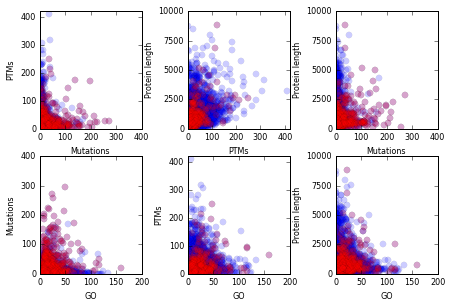

In [7]:
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols)
fig.tight_layout(pad=0.4, w_pad=2, h_pad=1.0)
SCATTER_SIZE=40
LABEL_SIZE = 8
idxCol = 0
idxRow = 0
ALPHA=0.2
BORDER_WIDTH=0.2
SHOW_LEGEND = False

# explicitly set tick labels to overide matplotlib's default spacing
TICKS = {'Mutations':np.arange(0,450,100), 'GO':np.arange(0,250,50), 'PTMs':np.arange(0,450,100),'Sequence':np.arange(0,12500,2500)}
LIMITS = {'GO':200, 'Mutations':400, 'PTMs':420,'Sequence':10000}
KEY_PAIRS = [['Mutations','PTMs'],['PTMs','Sequence'],['Mutations','Sequence'],['GO','Mutations'],['GO','PTMs'],['GO','Sequence']]                                                        

# loop generates a 6 pannel subplot
for KEY_PAIR in KEY_PAIRS:

    # set keys
    key1 = KEY_PAIR[0]
    key2 = KEY_PAIR[1]

    #plt.scatter(df[key1], df[key2],alpha=0.5,lw = 0.1,s=1.5,c='k')
    axes[idxRow, idxCol].scatter(df[key1], df[key2], alpha=ALPHA, lw = BORDER_WIDTH,s=SCATTER_SIZE)
    axes[idxRow, idxCol].scatter(df[key1][pathoS==1], df[key2][pathoS==1], c='r',alpha=ALPHA, lw = BORDER_WIDTH, s=SCATTER_SIZE)

    # set the plot object to the current axis for direct manipulation of plt variables
    plt.sca(axes[idxRow, idxCol])
    
    plt.xlim([0,LIMITS[key1]])
    plt.ylim([0,LIMITS[key2]])
    
    plt.xticks(TICKS[key1])
    plt.yticks(TICKS[key2])

    # change name for plots
    if key1 == 'Sequence':
        key1 = 'Protein length'
    if key2 == 'Sequence':
        key2 = 'Protein length'
    
    plt.xlabel(key1,size=LABEL_SIZE)
    plt.ylabel(key2,size=LABEL_SIZE)
    plt.tick_params(axis='x', labelsize=8)
    plt.tick_params(axis='y', labelsize=8)
    if SHOW_LEGEND:
        legend([L1,L2], LEGEND_TEXT,frameon=False,scatterpoints = 1)

    # update the row and column counter, resetting
    idxCol = idxCol + 1
    if idxCol % (ncols) == 0:
        idxCol = 0
        idxRow += 1

savefig("TEST_6_pannel_figure2.pdf",bbox_inches='tight')

## Filter for extreme outliers
Some proteins (here's looking at you, `p53`) have been extremely well studied and as such could skew statistics by having an order of magnitude more annotations than other proteins. We use the Z-score to remove outliers from the dataset. 

In [14]:
if FILTER:
    dfFilt = df[(np.abs(stats.zscore(df)) < 20).all(axis=1)]
    indexes = df[(np.abs(stats.zscore(df)) < 20).all(axis=1)].index.tolist()
    pathoSFilt = pathoS[indexes]
    protIdsFilt = protId_S[indexes]
    df_path = dfFilt[:][pathoSFilt==1]
    df = dfFilt
    pathoS = pathoSFilt
    protId_S = protIdsFilt
    protId_pathoS = protId_S[pathoSFilt==1]
else:
    df_path = df[:][pathoS==1]  
    protId_pathoS = protId_S[pathoS==1]


df_path.describe()
df_path.sum()

GO            14617
Mutations     18629
PTMs          16006
Sequence     588883
dtype: int64

## Correlation across annotations (all proteins)

In [10]:
rArr = []
pArr = []
keys = df.columns
s = ''
for i in range(0, len(keys)):
    key1 = keys[i]
    for j in range(i+1, len(keys)):
        key2 = keys[j]
        [r, p] = stats.pearsonr(df[key1], df[key2])
        rArr.append(r)
        pArr.append(p)
        s = "%s%s and %s have correlation \t%0.2f with pvalue of %0.E\n"%(s, key1, key2, r, p)
print s
        

GO and Mutations have correlation 	0.23 with pvalue of 3E-271
GO and PTMs have correlation 	0.28 with pvalue of 0E+00
GO and Sequence have correlation 	0.04 with pvalue of 1E-08
Mutations and PTMs have correlation 	0.15 with pvalue of 3E-113
Mutations and Sequence have correlation 	0.19 with pvalue of 4E-185
PTMs and Sequence have correlation 	0.46 with pvalue of 0E+00



In [11]:
df.corr()

,GO,Mutations,PTMs,Sequence
GO,1.000000,0.234234,0.282057,0.038250
Mutations,0.234234,1.000000,0.151826,0.194026
PTMs,0.282057,0.151826,1.000000,0.458828
Sequence,0.038250,0.194026,0.458828,1.000000


## Correlation across annotations (pathogenic proteins)

In [12]:
df_path.corr()


,GO,Mutations,PTMs,Sequence
GO,1.000000,0.186504,0.274064,0.114943
Mutations,0.186504,1.000000,0.159562,0.268098
PTMs,0.274064,0.159562,1.000000,0.537793
Sequence,0.114943,0.268098,0.537793,1.000000


## Enrichment in annotations
We're going to user Fisher's exact test to ask if there is enrichment in the set of proteins with pathogenic mutations for increased likelihood of having other annotation 

In [13]:
# Determine the total number of proteins (N) and the number of proteins
# with at least one pathogenic mutation (n)
N = len(df['Sequence'])
n = len(df_path['Sequence'])

# get the 
keys = df.columns
numThreshold = range(0, 30, 5)
for j in numThreshold:
    print "\nThreshold for terms > %d"%(j)
    for i in range(0, len(keys)-1):
   
        K_list = df[df[keys[i]]>j]
        k_list = df_path[df_path[keys[i]]>j]
        K = len(K_list[keys[i]])
        k = len(k_list[keys[i]])
        oddsratio, pvalue = stats.fisher_exact([[k, n-k], [K, N-K]], alternative='greater')
     
        print "%s:\t\t %0.E \t(N=%d, n=%d, K=%d, k=%d)"%(keys[i], pvalue, N, n, K, k)

    


Threshold for terms > 0
GO:		 1E-98 	(N=21941, n=777, K=15294, k=765)
Mutations:		 1E-212 	(N=21941, n=777, K=11529, k=777)
PTMs:		 1E+00 	(N=21941, n=777, K=21941, k=777)

Threshold for terms > 5
GO:		 6E-131 	(N=21941, n=777, K=9905, k=680)
Mutations:		 0E+00 	(N=21941, n=777, K=2404, k=584)
PTMs:		 1E-19 	(N=21941, n=777, K=12777, k=575)

Threshold for terms > 10
GO:		 2E-100 	(N=21941, n=777, K=5927, k=500)
Mutations:		 5E-310 	(N=21941, n=777, K=1057, k=426)
PTMs:		 9E-19 	(N=21941, n=777, K=8428, k=422)

Threshold for terms > 15
GO:		 2E-70 	(N=21941, n=777, K=3446, k=335)
Mutations:		 4E-259 	(N=21941, n=777, K=653, k=334)
PTMs:		 7E-17 	(N=21941, n=777, K=5922, k=319)

Threshold for terms > 20
GO:		 1E-56 	(N=21941, n=777, K=2122, k=238)
Mutations:		 1E-206 	(N=21941, n=777, K=447, k=260)
PTMs:		 2E-11 	(N=21941, n=777, K=4336, k=233)

Threshold for terms > 25
GO:		 3E-50 	(N=21941, n=777, K=1382, k=181)
Mutations:		 1E-178 	(N=21941, n=777, K=346, k=220)
PTMs:		 1E-10 	(N=219

## Save relevant data for enrichment analysis
Finally, we save the pathogenic protein data and the pathogenic protein IDs to use in the enrichment analysis 

In [9]:
pickle.dump([df_path, protId_pathoS], open("pathoProteins.p", "w"))